In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

from data_manipulation.reading_util import load_and_extract_2nd_class
from data_manipulation.reading_util import plot_report

load_dotenv()


2023-10-01 12:13:06.923767: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 12:13:06.983307: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 12:13:06.984234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 12:13:08.238511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

In [2]:
emb_path = os.getenv("ESM2_ENZYMES_SPLIT_100")
csv_path = os.getenv("CSV100_ENZYMES")
wanted_ec = 1

# Extracting 2nd ec class form wanted main class
----

LOG: 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split10.csv
LOG: 12 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split10.csv
LOG: 166 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split10.csv
LOG: 181 entries will be ignored
LOG: Data loaded in: 0.796 min
LOG: ESM2 of enzymes: 894
LOG: Labels of enzymes: 894


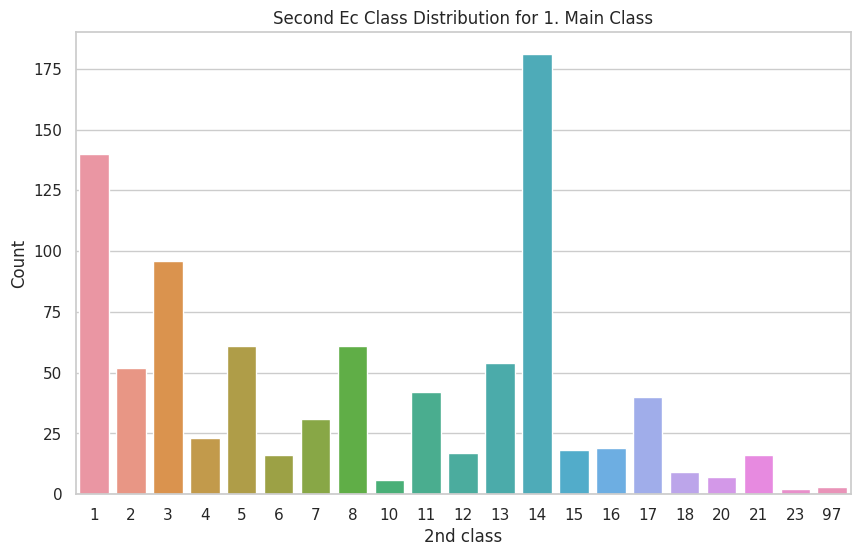

In [3]:
X, y, sec_to_label, label_to_sec = load_and_extract_2nd_class(path_to_esm2=emb_path,
                                                              path_to_enzyme_csv=csv_path,
                                                              wanted_ec_class=wanted_ec)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y)
plt.xticks(list(label_to_sec.keys()), list(sec_to_label.keys()))

# Add labels and title
plt.xlabel("2nd class")
plt.ylabel("Count")
plt.title(f"Second Ec Class Distribution for {wanted_ec}. Main Class")

# Show the plot
plt.show()


# Training a CNN based on amount of y_labels
----

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(sec_to_label))
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(sec_to_label))


In [5]:
print(y_test_encoded[0])


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
# Initializing the model
model = tf.keras.models.Sequential()

earl_stop = tf.keras.callbacks.EarlyStopping(patience=20)

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=len(sec_to_label), activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [15]:
model.fit(x=X_train, y=y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/100
23/23 [==============================] - 1s 22ms/step - loss: 2.8326 - val_loss: 2.5692
Epoch 2/100
23/23 [==============================] - 0s 12ms/step - loss: 2.6445 - val_loss: 2.4829
Epoch 3/100
23/23 [==============================] - 0s 12ms/step - loss: 2.5504 - val_loss: 2.4207
Epoch 4/100
23/23 [==============================] - 0s 12ms/step - loss: 2.4429 - val_loss: 2.2626
Epoch 5/100
23/23 [==============================] - 0s 14ms/step - loss: 2.2634 - val_loss: 2.1166
Epoch 6/100
23/23 [==============================] - 0s 12ms/step - loss: 2.1178 - val_loss: 2.0158
Epoch 7/100
23/23 [==============================] - 0s 12ms/step - loss: 2.0395 - val_loss: 1.8994
Epoch 8/100
23/23 [==============================] - 0s 11ms/step - loss: 1.9317 - val_loss: 1.8306
Epoch 9/100
23/23 [==============================] - 0s 14ms/step - loss: 1.7997 - val_loss: 1.7524
Epoch 10/100
23/23 [==============================] - 0s 15ms/step - loss: 1.7340 - val_loss: 1.6836

<Figure size 1000x600 with 0 Axes>

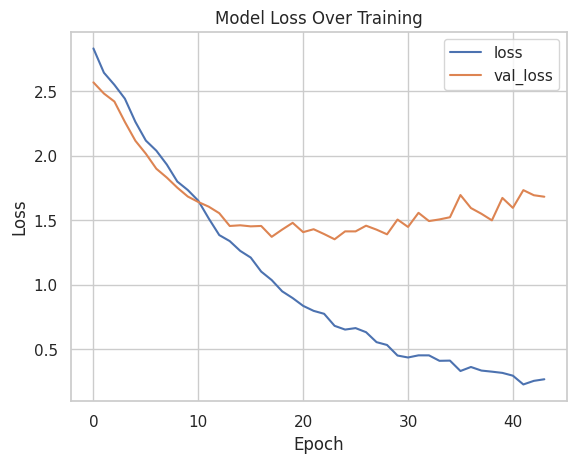

In [16]:
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [17]:
predictions = np.argmax(model.predict(X_test), axis=-1) 

6/6 [==============================] - 0s 3ms/step


In [18]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.77      0.71        31
           1       0.62      0.45      0.53        11
           2       0.62      0.65      0.63        20
           3       0.33      0.33      0.33         3
           4       0.71      0.31      0.43        16
           6       0.67      0.40      0.50         5
           7       1.00      0.71      0.83        14
           8       0.67      0.67      0.67         3
           9       0.50      1.00      0.67         7
          10       0.00      0.00      0.00         0
          11       0.73      0.80      0.76        10
          12       0.87      0.87      0.87        38
          13       1.00      0.75      0.86         4
          14       0.75      0.75      0.75         4
          15       0.50      1.00      0.67         6
          16       1.00      0.33      0.50         3
          17       0.00      0.00      0.00         1
          18       1.00    

/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/

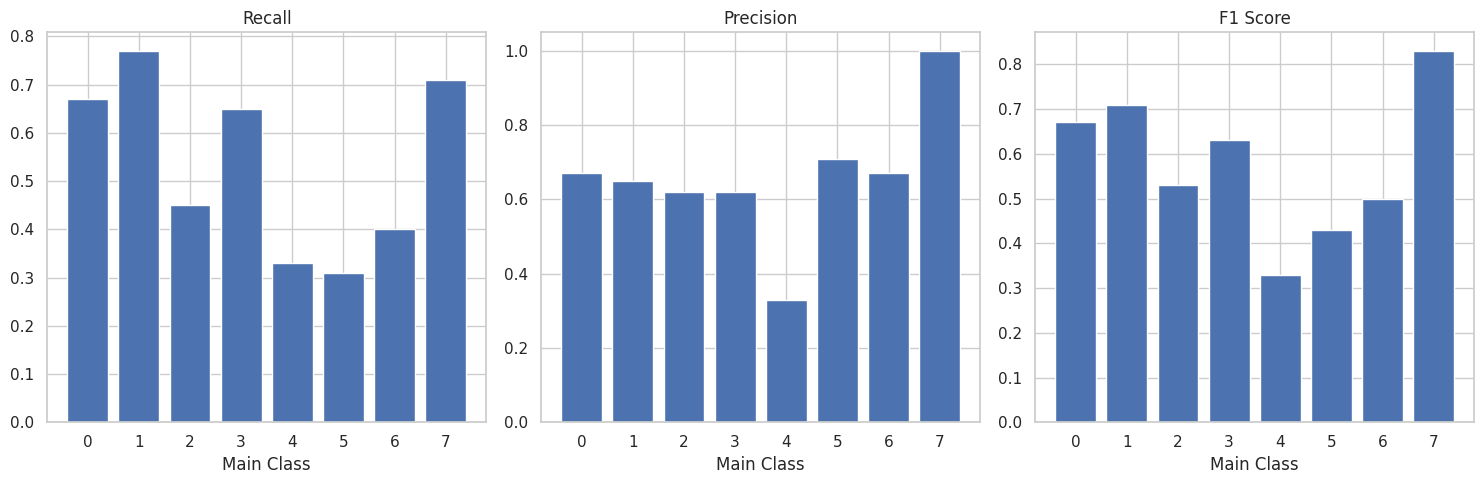

NameError: name 'confusion_matrix' is not defined

In [19]:
plot_report(report=report, y=y_test, predictions=predictions)